In [169]:
#!pip install dask[dataframe]
!pip install tpot

<b>Data loading</b>

In [170]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import glob
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

<b>Loading experiment data</b>

In [527]:
path = 'data/procedura'
all_files = glob.glob(path + '/*[0-9].txt')
seed=42
dataframes = []

len(all_files)
for path in all_files:
    with open(path) as f:
        dataframes.append(pd.read_csv(f, sep = '\t', names = [
            'PersonID',
            'StimulusID',
            'Consistency',
            'Condition',
            'Sound',
            'Image',
            'Widget',
            'Answer',
            'TimeToAnswer',
            'StimulusTimestamp'
        ],usecols = [
            'Sound',
            'Image',
            'Answer'
        ]))
        
df = pd.concat(dataframes)

<b>Preprocessing experiment data</b>

In [528]:
def extractValence(answer):
    return (float(answer.split(',')[0][1:])+1)*5
    
valenceCol = [extractValence(x) for x in df['Answer']]

def extractArousal(answer):
    return (float(answer.split(',')[1][:-1])+1)*5

arousalCol = [extractArousal(x) for x in df['Answer']]

def isEroticImage(imageId):
    if imageId >= 4001 and imageId <= 5000:
        return 1
    else:
        return 0
    
eroticImageCol = [isEroticImage(x) for x in df['Image']]

def isEroticSound(soundId):
    if soundId >= 200 and soundId <= 216:
        return 1
    else:
        return 0
    
eroticSoundCol = [isEroticSound(x) for x in df['Sound']]

#https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas
#https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
df = df.assign(ResearchValence=valenceCol)
df = df.assign(ResearchArousal=arousalCol)
df = df.assign(EroticImage=eroticImageCol)
df = df.assign(EroticSound=eroticSoundCol)

del df['Answer']
df.head()

,Sound,Image,ResearchValence,ResearchArousal,EroticImage,EroticSound
0,170,1112,5.002399,0.449335,0,0
1,373,9402,0.521854,4.978546,0,0
2,353,4660,8.317368,1.667026,1,0
3,277,3053,1.877277,8.310184,0,0
4,360,4656,9.509720,5.055283,1,0


<b>Load images and sounds<b>

In [529]:
dfImages = pd.read_csv('./data/IAPS.csv', # w pliku wszystke przecinki zamienione na kropki
                                  sep=';', 
                                  decimal=",",
                                  usecols=['IAPS', 'ValenceMean', 'ArousalMean'])
dfImages.IAPS = dfImages.IAPS.astype(int)
print('ImageValenceMean min: ' + str(dfImages['ValenceMean'].min()))
print('ImageValenceMean max: ' + str(dfImages['ValenceMean'].max()))
print('ImageArousalMean min: ' + str(dfImages['ArousalMean'].min()))
print('ImageArousalMean max: ' + str(dfImages['ArousalMean'].max()))
dfImages.head()

ImageValenceMean min: 1.31
ImageValenceMean max: 8.34
ImageArousalMean min: 1.72
ImageArousalMean max: 7.35


,IAPS,ValenceMean,ArousalMean
0,1019,3.95,5.77
1,1022,4.26,6.02
2,1026,4.09,5.61
3,1030,4.30,5.46
4,1033,3.87,6.13


In [534]:
dfSounds  = pd.read_csv('./data/IADS2.csv', 
                                  sep=';', 
                                  usecols=['Number', 'ValenceMean', 'ArousalMean'])

print('SoundValenceMean min: ' + str(dfSounds['ValenceMean'].min()))
print('SoundValenceMean max: ' + str(dfSounds['ValenceMean'].max()))
print('SoundArousalMean min: ' + str(dfSounds['ArousalMean'].min()))
print('SoundArousalMean max: ' + str(dfSounds['ArousalMean'].max()))
dfSounds.head()

SoundValenceMean min: 1.57
SoundValenceMean max: 7.9
SoundArousalMean min: 2.88
SoundArousalMean max: 8.16


,Number,ValenceMean,ArousalMean
0,102,4.63,4.91
1,104,4.96,5.37
2,105,2.88,6.40
3,106,3.37,6.39
4,107,5.47,5.85


<b>Creating a single dataframe</b>

In [535]:
def extractImageValenceMean(imageId):
    currentDf = dfImages[dfImages['IAPS']==imageId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ValenceMean']
    
imageValenceMeanCol = [extractImageValenceMean(x) for x in df['Image']]

In [536]:
def extractImageArousalMean(imageId):
    currentDf = dfImages[dfImages['IAPS']==imageId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ArousalMean']
    
imageArousalMeanCol = [extractImageArousalMean(x) for x in df['Image']]

In [537]:
def extractSoundValenceMean(soundId):
    currentDf = dfSounds[dfSounds['Number']==soundId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ValenceMean']

soundValenceMeanCol = [extractSoundValenceMean(x) for x in df['Sound']]

In [538]:
def extractSoundArousalMean(soundId):
    currentDf = dfSounds[dfSounds['Number']==soundId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ArousalMean']

soundArousalMeanCol = [extractSoundArousalMean(x) for x in df['Sound']]

In [539]:
df = df.assign(ImageValenceMean=imageValenceMeanCol)
df = df.assign(ImageArousalMean=imageArousalMeanCol)
df = df.assign(SoundValenceMean=soundValenceMeanCol)
df = df.assign(SoundArousalMean=soundArousalMeanCol)

del df['Sound']
del df['Image']

df.head()

,ResearchValence,ResearchArousal,EroticImage,EroticSound,ImageValenceMean,ImageArousalMean,SoundValenceMean,SoundArousalMean
0,5.002399,0.449335,0,0,4.71,4.60,5.31,4.60
1,0.521854,4.978546,0,0,4.48,5.07,5.09,4.65
2,8.317368,1.667026,1,0,7.40,6.58,7.38,6.62
3,1.877277,8.310184,0,0,1.31,6.91,1.63,7.79
4,9.509720,5.055283,1,0,6.73,6.41,6.94,7.54


In [616]:
#Podsumowanie połaczonego dataframe
df.describe(include='all')

,ResearchValence,ResearchArousal,EroticImage,EroticSound,ImageValenceMean,ImageArousalMean,SoundValenceMean,SoundArousalMean
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,4.454911,5.425000,0.164652,0.103846,4.517778,6.022269,4.864084,6.374817
std,2.538182,2.298985,0.370900,0.305089,2.201454,0.801469,1.941345,0.894736
min,0.000000,0.000000,0.000000,0.000000,1.310000,3.770000,1.630000,3.930000
25%,2.116026,4.114746,0.000000,0.000000,2.460000,5.670000,3.050000,5.890000
50%,4.796292,5.442619,0.000000,0.000000,4.470000,6.210000,5.090000,6.550000
75%,6.032511,7.081730,0.000000,0.000000,6.730000,6.580000,6.770000,6.980000
max,10.000000,10.000000,1.000000,1.000000,7.770000,7.350000,7.900000,7.990000


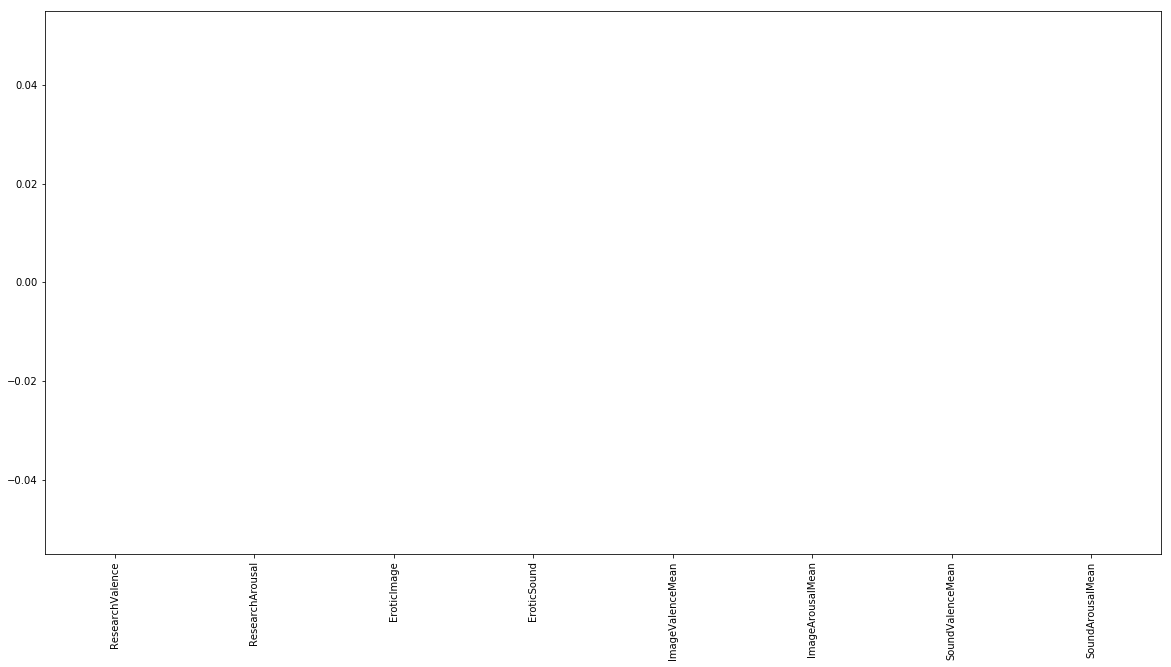

In [635]:
#Sprawdzam ile brakuje
df.isnull().sum().to_frame(name='count').sort_values(by='count', ascending=False)['count'].plot(kind='bar', figsize=(20,10))

Nie brakuje nic, wszystkie dane są poprawne, brak dziur

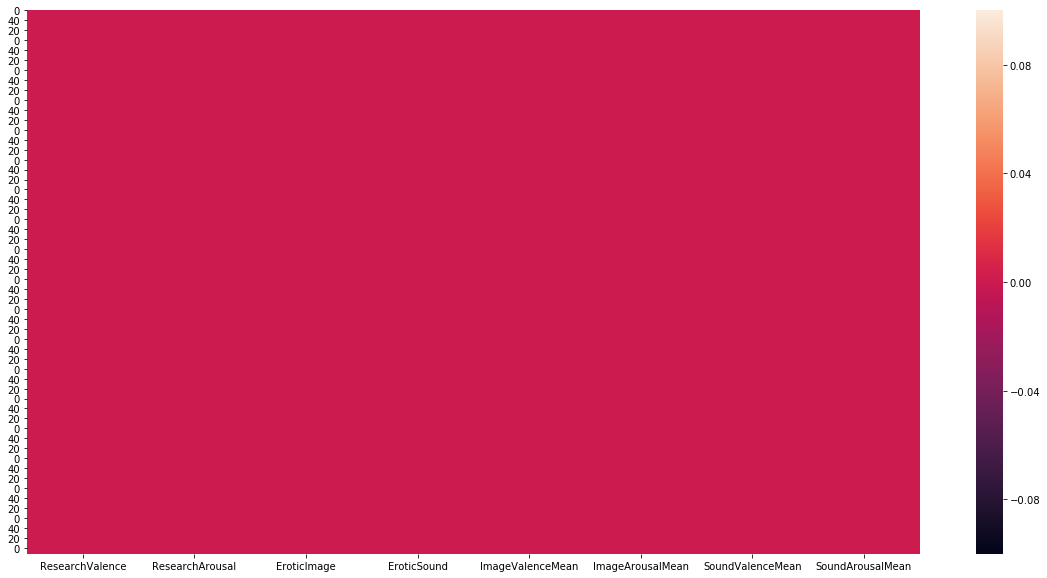

In [633]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull())

Dane pełne

In [634]:
df.count()

ResearchValence     5460
ResearchArousal     5460
EroticImage         5460
EroticSound         5460
ImageValenceMean    5460
ImageArousalMean    5460
SoundValenceMean    5460
SoundArousalMean    5460
dtype: int64

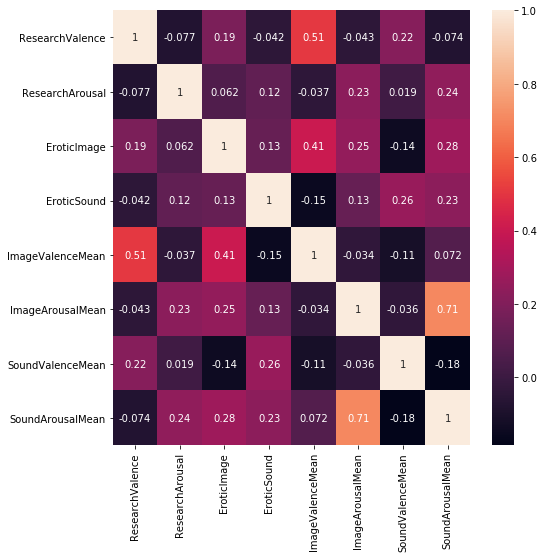

In [632]:
corr = df.corr(method='pearson')
plt.subplots(figsize=(8,8))
sns.heatmap(corr, annot=True)

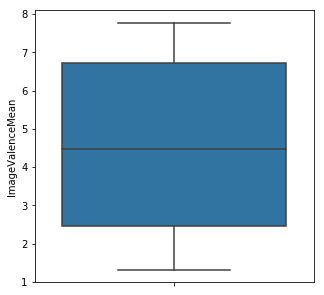

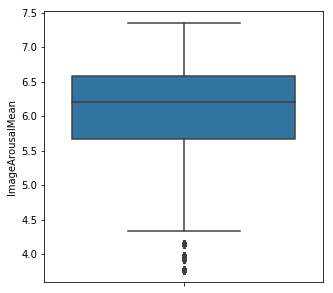

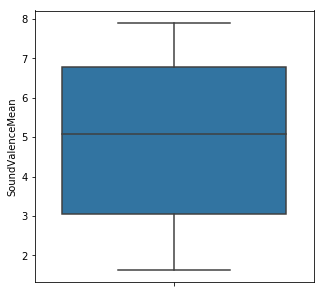

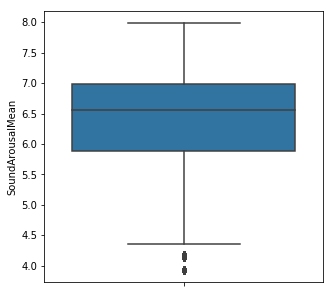

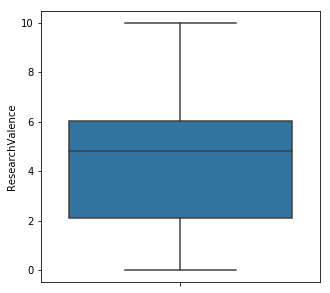

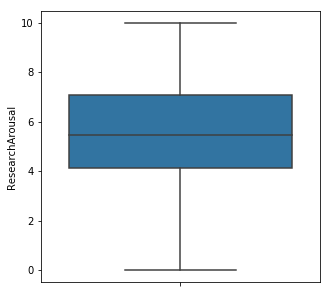

In [630]:
%matplotlib inline
plt.figure(figsize=(5, 5))
sns.boxplot(y=df.ImageValenceMean)
plt.figure(figsize=(5, 5))
sns.boxplot(y=df.ImageArousalMean)
plt.figure(figsize=(5, 5))
sns.boxplot(y=df.SoundValenceMean)
plt.figure(figsize=(5, 5))
sns.boxplot(y=df.SoundArousalMean)
plt.figure(figsize=(5, 5))
sns.boxplot(y=df.ResearchValence)
plt.figure(figsize=(5, 5))
sns.boxplot(y=df.ResearchArousal)

# <b> Valence Regression </b>

0.7283077164253595
[ 0.15112436 -0.2188637   0.62382824  0.16880199  0.35496713 -0.28452674]


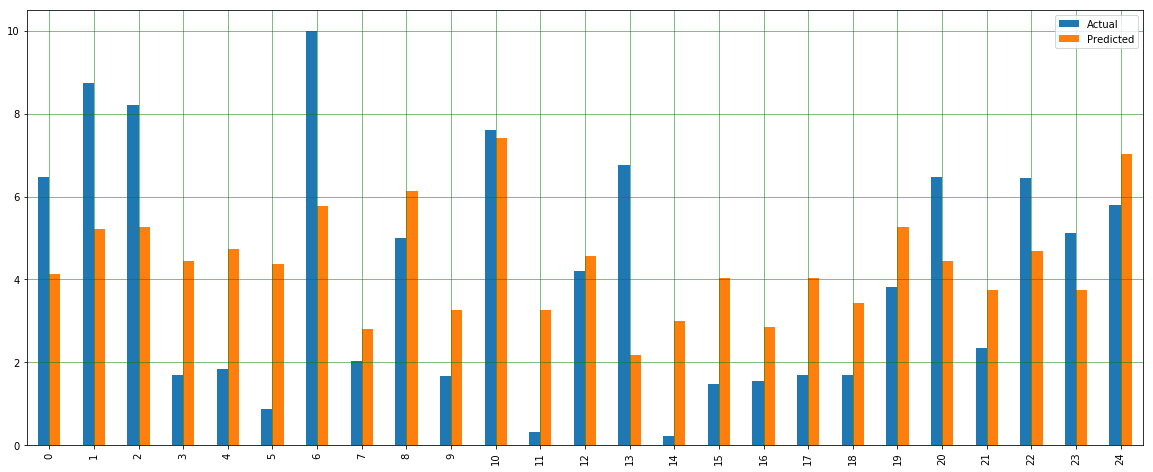

Mean Absolute Error: 1.6910470499752288
Mean Squared Error: 4.580861656318024
Root Mean Squared Error: 2.1402947592137918


In [600]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics

X = df[['EroticImage','EroticSound','ImageValenceMean','ImageArousalMean','SoundValenceMean','SoundArousalMean']].values
y = df['ResearchValence'].values #to predict


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)


y_pred = regressor.predict(X_test)

df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df2 = df1.head(25)


df2.plot(kind='bar',figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


# <b>Arousal Regression</b>

0.9331148695063538
[-0.01012209  0.30403973 -0.0336656   0.28426462  0.05209222  0.41400855]


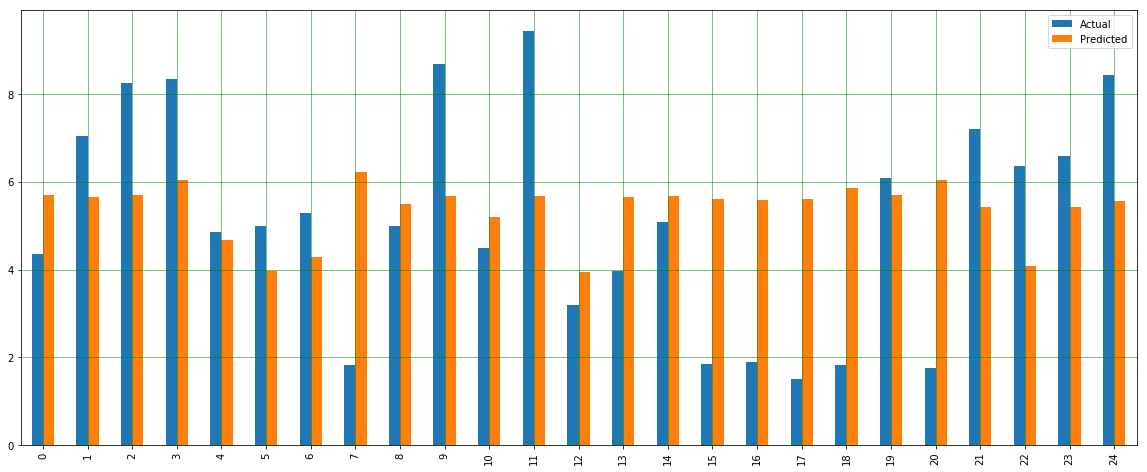

Mean Absolute Error: 1.731966538109642
Mean Squared Error: 4.788925584674906
Root Mean Squared Error: 2.1883613926120398


In [598]:
X = df[['EroticImage','EroticSound','ImageValenceMean','ImageArousalMean','SoundValenceMean','SoundArousalMean']].values
y = df['ResearchArousal'].values #to predict


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)


y_pred = regressor.predict(X_test)

df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df2 = df1.head(25)


df2.plot(kind='bar',figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

AttributeError: module 'sklearn.metrics' has no attribute 'neg_mean_squared_error'